# 1. Introduction and Overview

This notebook provides a comprehensive framework for analyzing text data to study creativity in solutions using embedding models. It computes embeddings using multiple state-of-the-art models, visualize these embeddings, and apply various analytical techniques to identify and measure creative aspects of textual solutions.
The primary goals of this framework are to:

- Transform textual solutions into numerical vector representations (embeddings)
- Visualize similarities and differences between solutions
- Identify outliers that may represent highly creative or unique approaches
- Cluster similar solutions to understand common patterns
- Quantify the diversity and uniqueness of solution sets

By comparing the semantic positioning of solutions in embedding space, we can gain insights into creative thinking processes, solution diversity, and innovation patterns.

#TODO: Your key

In [3]:
import os
# Set your OpenAI API key
os.environ["OPENAI_API_KEY"] = "your_key"  # Replace with your API key. Costs should be $0.13 per 1M input tokens (that's a very low cost).

# Imports

In [4]:
# Text Embeddings Analysis for Creativity Research
# This notebook computes and analyzes embeddings from multiple models to study creativity in solutions
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import torch
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
# import openai
from tqdm.notebook import tqdm
import plotly.express as px

from scipy.spatial.distance import pdist, squareform
import matplotlib.patches as mpatches
from typing import List, Dict

# Display settings
pd.set_option('display.max_colwidth', None)

In [5]:
import pandas as pd
import re
import os
# from google.colab import files
from tqdm import tqdm

tqdm.pandas()

# Make sure to execute all code below. No changes needed so far.

# Embedding functions

### OpenAI Embeddings

The get_openai_embeddings function connects to OpenAI's API to generate state-of-the-art text embeddings. OpenAI's latest embedding models (text-embedding-3-large) provide high-quality semantic representations that capture nuanced meanings and relationships between concepts, making them excellent for creativity research.
### EuroBERT Embeddings
The get_eurobert_embeddings function uses the EuroBERT model to generate embeddings that are particularly well-suited to European language contexts. EuroBERT offers robust representations that may capture certain cultural and contextual nuances in European languages that might be relevant for creativity research.
### SentenceBERT Embeddings
The get_sentencebert_embeddings function uses the SentenceBERT framework, which is specifically optimized for generating meaningful sentence-level embeddings. SentenceBERT models are fine-tuned specifically for semantic similarity tasks, making them particularly valuable for comparing creative solutions.

Note: If your dataset is large (>200 samples and/or >500 tokens per sample), you may want to turn on GPU runtime type for the EuroBERT and SentenceBERT embeddings.

In [6]:
def get_openai_embeddings(texts: List[str], model: str = "text-embedding-3-large") -> np.ndarray:
    """Compute text embeddings using OpenAI's latest embedding model."""
    openai.api_key = os.getenv("OPENAI_API_KEY")
    if not openai.api_key:
        raise ValueError("OpenAI API key not found. Please set it in the notebook.")

    embeddings = []
    batch_size = 100  # OpenAI recommends batching requests

    for i in tqdm(range(0, len(texts), batch_size), desc="Computing OpenAI embeddings"):
        batch = texts[i:i+batch_size]
        response = openai.embeddings.create(
            model=model,
            input=batch
        )
        batch_embeddings = [item.embedding for item in response.data]
        embeddings.extend(batch_embeddings)

    return np.array(embeddings)

def get_eurobert_embeddings(texts: List[str], model_name: str = "EuroBERT/EuroBERT-210m") -> np.ndarray:
    """
    Compute text embeddings using EuroBERT with proper truncation handling.

    This function handles long texts by properly truncating them to the model's
    maximum sequence length while ensuring embeddings are correctly extracted.

    Args:
        texts: List of text strings to embed
        model_name: Name of the EuroBERT model to use

    Returns:
        NumPy array of embeddings
    """
    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name, trust_remote_code=True)

    # Set device (GPU if available, otherwise CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    embeddings = []
    batch_size = 8  # Further reduced batch size to handle longer sequences (8K tokens)

    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="Computing EuroBERT embeddings"):
            batch = texts[i:i+batch_size]

            # Tokenize with explicit truncation to handle long texts properly
            # Truncate to 8192 tokens since EuroBERT can handle up to 8K tokens
            encoded_input = tokenizer(
                batch,
                padding='max_length',  # Use consistent padding
                truncation=True,       # Enable truncation
                max_length=8192,       # Set maximum length to 8K tokens
                return_tensors='pt',   # Return PyTorch tensors
                return_attention_mask=True  # Get attention mask to handle padding properly
            )

            # Move tensors to device
            encoded_input = {k: v.to(device) for k, v in encoded_input.items()}

            # Forward pass through the model
            outputs = model(**encoded_input)

            # Get the attention mask to properly handle padding
            attention_mask = encoded_input['attention_mask']

            # Different ways to get sentence embeddings:

            # Method 1: CLS token embedding (first token)
            # This is standard for BERT sentence representations
            cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()

            # Method 2 (alternative): Mean of all token embeddings, weighted by attention mask
            # This can sometimes provide better representations for long texts
            # mean_embeddings = []
            # for j in range(len(batch)):
            #     # Get the token embeddings for this sequence
            #     token_embeddings = outputs.last_hidden_state[j]
            #     # Get the attention mask for this sequence
            #     mask = attention_mask[j]
            #     # Compute the mean of the token embeddings, weighted by the mask
            #     masked_embeddings = token_embeddings * mask.unsqueeze(-1)
            #     sum_embeddings = torch.sum(masked_embeddings, dim=0)
            #     seq_length = torch.sum(mask)
            #     mean_embedding = sum_embeddings / seq_length
            #     mean_embeddings.append(mean_embedding.cpu().numpy())
            # embeddings.extend(mean_embeddings)

            # Using CLS token embeddings (Method 1)
            embeddings.extend(cls_embeddings)

    # Convert list to numpy array
    embeddings_array = np.array(embeddings)

    # Normalize embeddings (important for cosine similarity)
    norms = np.linalg.norm(embeddings_array, axis=1, keepdims=True)
    normalized_embeddings = embeddings_array / norms

    return normalized_embeddings

def get_sentencebert_embeddings(texts: List[str], model_name: str = "all-mpnet-base-v2") -> np.ndarray:
    """Compute text embeddings using SentenceBERT."""
    # Load model
    model = SentenceTransformer(model_name)

    # Set device (GPU if available, otherwise CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Compute embeddings with normalization
    embeddings = model.encode(
        texts,
        batch_size=16,
        show_progress_bar=True,
        convert_to_numpy=True,
        normalize_embeddings=True  # Normalize for cosine similarity
    )

    return embeddings

#########################
# Visualization Functions #
#########################

In [7]:
def reduce_with_pca(embeddings: np.ndarray, n_components: int = 2) -> np.ndarray:
    """Reduce dimensionality using PCA."""
    pca = PCA(n_components=n_components)
    return pca.fit_transform(embeddings)

def reduce_with_tsne(embeddings: np.ndarray, n_components: int = 2, perplexity: int = 30) -> np.ndarray:
    """Reduce dimensionality using t-SNE."""
    # Adjust perplexity if it's larger than the number of samples
    n_samples = embeddings.shape[0]
    if perplexity >= n_samples:
        # Set perplexity to n_samples/3 or 5, whichever is smaller but at least 2
        adjusted_perplexity = max(2, min(5, n_samples // 3))
        print(f"Warning: Perplexity ({perplexity}) must be less than n_samples ({n_samples}). "
              f"Adjusting perplexity to {adjusted_perplexity}.")
        perplexity = adjusted_perplexity

    # Use max_iter instead of n_iter to avoid deprecation warning
    tsne = TSNE(n_components=n_components, perplexity=perplexity, max_iter=1000, random_state=42)
    return tsne.fit_transform(embeddings)

def visualize_embeddings(embeddings: np.ndarray, labels=None, title: str = "Embedding Visualization",
                         reduction_methods: List[str] = ["PCA", "t-SNE"], color_by=None):
    """Visualize embeddings using dimensionality reduction."""
    fig, axes = plt.subplots(1, len(reduction_methods), figsize=(18, 7))

    if len(reduction_methods) == 1:
        axes = [axes]

    for i, method in enumerate(reduction_methods):
        if method == "PCA":
            reduced_embeddings = reduce_with_pca(embeddings)
            method_title = "PCA"
        elif method == "t-SNE":
            reduced_embeddings = reduce_with_tsne(embeddings)
            method_title = "t-SNE"
        else:
            raise ValueError(f"Unknown reduction method: {method}")

        # Create scatter plot
        df_plot = pd.DataFrame(reduced_embeddings, columns=["x", "y"])

        if labels is not None:
            df_plot["label"] = labels

        if color_by is not None:
            scatter = axes[i].scatter(df_plot["x"], df_plot["y"], c=color_by, cmap="coolwarm", alpha=0.8, s=100)
            plt.colorbar(scatter, ax=axes[i], label="Value")
        else:
            axes[i].scatter(df_plot["x"], df_plot["y"], alpha=0.8, s=100)

        axes[i].set_title(f"{title} - {method_title}", fontsize=14)
        axes[i].set_xlabel("Dimension 1", fontsize=12)
        axes[i].set_ylabel("Dimension 2", fontsize=12)
        axes[i].grid(True, linestyle="--", alpha=0.7)

    plt.tight_layout()
    plt.show()

def create_interactive_plot(embeddings: np.ndarray, df: pd.DataFrame, method: str = "t-SNE",
                           color_by: str = None, hover_data: List[str] = None):
    """Create an interactive visualization of embeddings."""
    if method == "PCA":
        reduced_embeddings = reduce_with_pca(embeddings)
    elif method == "t-SNE":
        reduced_embeddings = reduce_with_tsne(embeddings)
    else:
        raise ValueError(f"Unknown reduction method: {method}")

    df_plot = pd.DataFrame(reduced_embeddings, columns=["dim_1", "dim_2"])

    if hover_data:
        for col in hover_data:
            if col in df.columns:
                df_plot[col] = df[col].values

    # Add color column if specified
    if color_by and color_by in df.columns:
        df_plot[color_by] = df[color_by].values

    fig = px.scatter(
        df_plot,
        x="dim_1",
        y="dim_2",
        color=color_by if color_by else None,
        hover_data=hover_data,
        title=f"Embedding Visualization using {method}",
        labels={"dim_1": "Dimension 1", "dim_2": "Dimension 2"},
        template="plotly_white"
    )

    fig.update_traces(marker=dict(size=10, opacity=0.8))
    fig.update_layout(height=700, width=1000)

    fig.show()

def compute_cosine_similarity_matrix(embeddings: np.ndarray) -> np.ndarray:
    """Compute cosine similarity matrix between all embeddings."""
    similarity_matrix = cosine_similarity(embeddings)
    return similarity_matrix

def visualize_similarity_matrix(similarity_matrix: np.ndarray, labels=None, title: str = "Cosine Similarity Matrix"):
    """Visualize cosine similarity matrix as a heatmap."""
    plt.figure(figsize=(12, 10))

    # Create heatmap
    sns.heatmap(
        similarity_matrix,
        annot=False,
        cmap="coolwarm",
        xticklabels=labels if labels else False,
        yticklabels=labels if labels else False
    )

    plt.title(title, fontsize=15)
    plt.tight_layout()
    plt.show()

#############################
# Creativity Analysis Tools #
#############################

In [8]:
def identify_creative_outliers(embeddings: np.ndarray, threshold: float = 1.5) -> List[int]:
    """Identify potential creative outliers based on distance to centroid."""
    # Compute centroid
    centroid = np.mean(embeddings, axis=0)

    # Compute distances to centroid
    distances = np.sqrt(np.sum((embeddings - centroid)**2, axis=1))

    # Identify outliers
    mean_dist = np.mean(distances)
    std_dist = np.std(distances)
    outlier_indices = np.where(distances > mean_dist + threshold * std_dist)[0]

    return outlier_indices.tolist()

def cluster_solutions(embeddings: np.ndarray, n_clusters: int = 5) -> np.ndarray:
    """Cluster solutions to identify groups of similar approaches."""
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(embeddings)

    return cluster_labels

def visualize_clusters(embeddings: np.ndarray, cluster_labels: np.ndarray,
                      method: str = "PCA", title: str = "Solution Clusters"):
    """Visualize clusters of solutions."""
    if method == "PCA":
        reduced_embeddings = reduce_with_pca(embeddings)
    elif method == "t-SNE":
        reduced_embeddings = reduce_with_tsne(embeddings)
    else:
        raise ValueError(f"Unknown reduction method: {method}")

    plt.figure(figsize=(12, 10))

    # Create scatter plot with clusters colored
    scatter = plt.scatter(
        reduced_embeddings[:, 0],
        reduced_embeddings[:, 1],
        c=cluster_labels,
        cmap="tab10",
        alpha=0.8,
        s=120
    )

    # Add legend
    n_clusters = len(np.unique(cluster_labels))
    legend_handles = [mpatches.Patch(color=scatter.cmap(scatter.norm(i)), label=f"Cluster {i}")
                     for i in range(n_clusters)]
    plt.legend(handles=legend_handles, fontsize=12)

    plt.title(title, fontsize=15)
    plt.xlabel("Dimension 1", fontsize=12)
    plt.ylabel("Dimension 2", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

def compute_diversity_metrics(embeddings: np.ndarray) -> Dict[str, float]:
    """Compute metrics for measuring the diversity of solutions."""
    # Compute centroid
    centroid = np.mean(embeddings, axis=0)

    # Compute distances to centroid
    distances = np.sqrt(np.sum((embeddings - centroid)**2, axis=1))

    # Compute pairwise distances
    pairwise_distances = squareform(pdist(embeddings, metric='cosine'))

    # Compute diversity metrics
    metrics = {
        "mean_distance_to_centroid": np.mean(distances),
        "max_distance_to_centroid": np.max(distances),
        "mean_pairwise_distance": np.mean(pairwise_distances),
        "max_pairwise_distance": np.max(pairwise_distances),
        "variance_explained_ratio": np.var(distances) / np.sum(np.var(embeddings, axis=0))
    }

    return metrics

def compare_similarity_matrices(embedding_results: Dict, labels=None, title: str = "Cosine Similarity Comparison",
                           colormaps: List[str] = ["coolwarm", "coolwarm", "coolwarm"]):
    """Compare cosine similarity matrices from different embedding models side by side.

    Args:
        embedding_results: Dictionary containing embedding results from multiple models
        labels: Optional labels for the axes
        title: Overall title for the comparison
        colormaps: List of colormaps to use for each model (should match the number of models)
    """
    # Get the models we have results for
    models = list(embedding_results.keys())
    n_models = 1

    # Create a figure with n_models subplots in one row
    fig, axes = plt.subplots(1, n_models, figsize=(n_models * 5, 4))

    # If there's only one model, make axes iterable
    if n_models == 1:
        axes = [axes]

    # Ensure we have enough colormaps
    if len(colormaps) < n_models:
        colormaps = colormaps + [colormaps[-1]] * (n_models - len(colormaps))

    # Find global min and max for consistent color scaling
    all_sim_values = []
    all_sim_values.extend(embedding_results["similarity_matrix"].flatten())
    vmin = min(all_sim_values)
    vmax = max(all_sim_values)

    similarity_matrix = embedding_results["similarity_matrix"]

    # Create heatmap on the current axis
    sns.heatmap(
        similarity_matrix,
        annot=False,
        cmap=colormaps[0],
        xticklabels=labels if labels else False,
        yticklabels=labels if labels else False,
        vmin=vmin,
        vmax=vmax,
        ax=axes[0]
    )

    axes[0].set_title(f"CLIP Similarity", fontsize=12)

    # Add an overall title
    fig.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for the suptitle
    plt.show()

In [9]:
def compute_individual_distances(
    results: Dict,
    embedding_key: str = "embeddings",
) -> Dict[str, np.ndarray]:
    """
    For each solution embedding, compute:
      - dist_to_centroid: Euclidean distance to the mean embedding (centroid)
      - avg_pairwise_distance: average cosine distance to all other embeddings
    Returns a dict with two arrays of shape (n_samples,).
    """
    embeddings = np.vstack(results[embedding_key])
    
    # 1. Centroid and distances to it
    centroid = np.mean(embeddings, axis=0)
    dist_to_centroid = np.linalg.norm(embeddings - centroid, axis=1)

    # 2. Pairwise cosine‐distance matrix
    pairwise_cosine = squareform(pdist(embeddings, metric='cosine'))

    # 3. Compute per‐row average excluding self (diagonal zeros)
    n = embeddings.shape[0]
    # sum of distances in each row divided by (n‑1)
    avg_pairwise_distance = pairwise_cosine.sum(axis=1) / (n - 1)

    return {
        "dist_to_centroid": dist_to_centroid,
        "avg_pairwise_distance": avg_pairwise_distance
    }


In [10]:
import numpy as np
import matplotlib.pyplot as plt

def plot_distance_heatmaps(embedding_results: Dict[str, dict],
                           figsize = (12, 2)):
    """
    For each embedding model in embedding_results, compute per‐solution distances
    (to centroid and to peers) and plot a 2×N heatmap.

    Args:
        embedding_results: dict mapping model name to dict with key "embeddings".
        figsize: size of each heatmap figure.
    """
    # compute distances
    d = compute_individual_distances(embedding_results, 'embeddings')
    dist_to_centroid      = d["dist_to_centroid"]
    avg_pairwise_distance = d["avg_pairwise_distance"]

    # stack into 2×N matrix
    dist_matrix = np.vstack([dist_to_centroid, avg_pairwise_distance])

    # plot
    plt.figure(figsize=figsize)
    plt.imshow(dist_matrix, aspect='auto')
    plt.yticks([0, 1], ["Dist to Centroid", "Avg Dist to Others"])
    plt.xticks(np.arange(dist_matrix.shape[1]), np.arange(dist_matrix.shape[1]))
    plt.xlabel("Solution Index")
    plt.title(f"CLIP Distances Heatmap")
    plt.colorbar(label="Distance")
    plt.tight_layout()
    plt.show()


#######################
# Main Analysis Flow #
#######################

In [11]:
from typing import Iterable, Optional, Sequence, Union

def analyze_embeddings(
    df: pd.DataFrame,
    embedding_col:str
):
    """
    Analyze text embeddings for a given DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the text to embed.
    text_column : str, default "text_to_embed"
        Name of the column that holds the raw text.
    models : str | Iterable[str] | None, optional
        Which embedding model(s) to apply.
        - None (default) → run every supported model.
        - "openai", "eurobert", "sentencebert" → run just that model.
        - Iterable of the above → run the selected subset.

    Returns
    -------
    dict
        A mapping of model name → {"embeddings": np.ndarray,
                                   "similarity_matrix": np.ndarray}
    """
    # ------------------------- compute embeddings -------------------------
    results = {
        "embeddings": df[embedding_col].values,
        "similarity_matrix": compute_cosine_similarity_matrix(np.vstack(df[embedding_col].values)),
    }

    # --------------------------- visualisations ---------------------------
    print("\nCreating visualizations...")
    print("Visualizing CLIP embeddings:")
    visualize_embeddings(
        np.vstack(results["embeddings"]),
        title="CLIP Embeddings",
        reduction_methods=["PCA", "t-SNE"],
    )

    print("\nVisualizing CLIP similarity matrix:")
    visualize_similarity_matrix(
        results["similarity_matrix"],
        title="CLIP Cosine Similarity Matrix",
    )

    return results

In [12]:
def analyze_creativity(df: pd.DataFrame, embedding_key: str = 'embeddings', text_column: str = "text_to_embed"):
    """Perform creativity analysis on embeddings."""
    print("Performing creativity analysis...")
    embeddings = np.vstack(df[embedding_key].values)

    # 1. Identify potential creative outliers
    outlier_indices = identify_creative_outliers(embeddings)
    # print(f"\nPotential creative outliers (unusual solutions):")
    # if outlier_indices:
    #     for idx in outlier_indices:
    #         print(f"Index {idx}: {df.iloc[idx][text_column][:100]}...")  # Print first 100 chars
    # else:
    #     print("No significant outliers found.")

    # 2. Cluster solutions
    # More conservative cluster selection for small datasets
    n_clusters = min(3, max(2, len(df) // 3))  # Ensure appropriate number of clusters for sample size
    print(f"Using {n_clusters} clusters for analysis based on dataset size ({len(df)} samples)")
    cluster_labels = cluster_solutions(embeddings, n_clusters=n_clusters)

    # Add cluster labels to DataFrame
    df_analysis = df.copy()
    df_analysis["cluster"] = cluster_labels

    print(f"\nSolution clusters:")
    for cluster_id in range(n_clusters):
        cluster_size = np.sum(cluster_labels == cluster_id)
        print(f"Cluster {cluster_id}: {cluster_size} solutions")

    # 3. Visualize clusters
    visualize_clusters(embeddings, cluster_labels, method="PCA", title="Solution Clusters (PCA)")
    visualize_clusters(embeddings, cluster_labels, method="t-SNE", title="Solution Clusters (t-SNE)")

    # 4. Compute diversity metrics
    diversity_metrics = compute_diversity_metrics(embeddings)

    print("\nDiversity metrics:")
    for metric, value in diversity_metrics.items():
        print(f"{metric}: {value:.4f}")

    # 5. Interactive visualization with cluster coloring
    create_interactive_plot(
        embeddings,
        df_analysis,
        method="t-SNE",
        color_by="cluster",
        # hover_data=[text_column] + [col for col in df.columns if col != text_column]
    )

    return df_analysis

# 4. Category-specific similarity analysis

In [13]:
# ──────────────────────────────────────────────────────────────
# 4. Category-specific similarity analysis  (subplot + grouping)
# ──────────────────────────────────────────────────────────────
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from collections.abc import Mapping


def _apply_category_mapping(series: pd.Series, combine_map=None) -> pd.Series:
    """
    Returns a new Series with original labels collapsed to the user-supplied
    mapping.

    combine_map can take EITHER of two flavours:
      1) {'Low': ['0', '1', '2'], 'Mid': ['A','B','C']}
            (keys = NEW labels, values = list/tuple of OLD labels)
      2) {'0': 'Low', '1': 'Low', '2': 'Low', 'A': 'Mid', ...}
            (keys = OLD labels, values = NEW label)
    Any label not mentioned stays untouched.
    """
    if not combine_map:
        return series.copy()

    # convert flavour-1 into flavour-2 for uniform treatment
    if any(isinstance(v, (list, tuple, set)) for v in combine_map.values()):
        mapping = {old: new for new, olds in combine_map.items() for old in olds}
    else:                       # already flavour-2
        mapping = dict(combine_map)

    return series.map(lambda x: mapping.get(x, x))   # default: original


def category_similarity_distributions(
        df: pd.DataFrame,
        embedding_col: str = "embedding",
        category_col: str = "category",
        bw_adjust: float = .6,
        scale_to_percent: bool = False,
        combine_map: Mapping = None
):
    """
    Same functionality as before, but now:
      • plots appear in a single Figure with 2 columns
      • categories can be merged via `combine_map` (see docstring above)
    """
    # ── sanity checks ────────────────────────────────────────────────
    if embedding_col not in df.columns or category_col not in df.columns:
        raise ValueError(f"Need both `{embedding_col}` and `{category_col}` columns.")

    # ── clone df & apply any grouping collapse ──────────────────────
    df = df.copy()
    df["_plot_cat"] = _apply_category_mapping(df[category_col], combine_map)
    cat_col = "_plot_cat"
    cats = df[cat_col].unique()

    # ── pre-compute similarities once ───────────────────────────────
    emb_matrix = np.vstack(df[embedding_col].to_numpy())
    full_cos    = cosine_similarity(emb_matrix)

    centroids = (df.groupby(cat_col)[embedding_col]
                   .apply(lambda v: np.mean(np.vstack(v), axis=0)))

    sim_to_centroid   = np.zeros(len(df))
    avg_pairwise_same = np.zeros(len(df))

    for i, (cat, emb_vec) in enumerate(zip(df[cat_col], emb_matrix)):
        sim_to_centroid[i] = cosine_similarity(
            emb_vec.reshape(1, -1),
            centroids[cat].reshape(1, -1)
        )[0, 0]

        same_idx = df.index[df[cat_col] == cat].tolist()
        avg_pairwise_same[i] = (
            (full_cos[i, same_idx].sum() - 1) / (len(same_idx) - 1)
            if len(same_idx) > 1 else np.nan
        )

    df["sim_to_cat_mean"]      = sim_to_centroid
    df["avg_pairwise_samecat"] = avg_pairwise_same

    # ── figure layout  (two plots per row) ──────────────────────────
    n_cross = len(cats)        # potential “other” categories
    n_rows = 1 + n_cross       # 1 row for each pair of plots
    fig, axes = plt.subplots(n_rows, 2, figsize=(12, 4 * n_rows))
    axes = np.atleast_2d(axes)                       # ensure 2-D indexing

    # helper to scale & plot on the right axis
    def _kde(ax, data, label):
        if scale_to_percent:
            data = 100 * data
        sns.kdeplot(data.dropna(), ax=ax, label=str(label), bw_adjust=bw_adjust)

    # ── row 0  : similarity to own centroid ─────────────────────────
    ax0 = axes[0, 0]
    for cat in cats:
        _kde(ax0, df.loc[df[cat_col] == cat, "sim_to_cat_mean"], cat)
    ax0.set(title="Similarity → own centroid", xlabel="Cosine similarity", ylabel="Density")
    ax0.legend()

    # ── row 0  : avg pair-wise within category ──────────────────────
    ax1 = axes[0, 1]
    for cat in cats:
        _kde(ax1, df.loc[df[cat_col] == cat, "avg_pairwise_samecat"], cat)
    ax1.set(title="Avg pair-wise similarity (within cat.)", xlabel="Cosine similarity")
    ax1.legend()

    # ── rows 1… : cross-category comparisons  (one “other” per row) ─
    row = 1
    for other in cats:
        # similarity to OTHER centroid
        other_cent = centroids[other].reshape(1, -1)
        df[f"sim_to_{other}_centroid"] = cosine_similarity(emb_matrix, other_cent)[:, 0]

        # similarity to OTHER items
        other_idx = df.index[df[cat_col] == other].tolist()
        df[f"avg_sim_to_{other}"] = full_cos[:, other_idx].mean(axis=1)

        mask_not_other = df[cat_col] != other

        #  col-0  : to OTHER centroid
        ax_left = axes[row, 0]
        for cat in cats:
            if cat == other:
                continue
            _kde(ax_left,
                 df.loc[(df[cat_col] == cat) & mask_not_other,
                        f"sim_to_{other}_centroid"],
                 cat)
        ax_left.set(title=f"Similarity → {other} centroid", ylabel="Density")

        #  col-1  : to OTHER items
        ax_right = axes[row, 1]
        for cat in cats:
            if cat == other:
                continue
            _kde(ax_right,
                 df.loc[(df[cat_col] == cat) & mask_not_other,
                        f"avg_sim_to_{other}"],
                 cat)
        ax_right.set(title=f"Avg similarity with items in {other}")

        ax_left.legend(title="Source cat.")
        row += 1

    plt.tight_layout()

    # 1) collect all axes into a flat list
    axs = axes.flatten()

    # 2) set x-range (only makes sense when scale_to_percent is True)
    if scale_to_percent:
        for ax in axs:
            ax.set_xlim(0, 100)

    # 3) find the highest y-limit that any subplot auto-selected
    common_ymax = max(ax.get_ylim()[1] for ax in axs)

    # 4) apply that y-limit to every subplot
    for ax in axs:
        ax.set_ylim(0, common_ymax)
    # ──────────────────────────────────────────────────────────────

    plt.show()

    return df

In [14]:
# ──────────────────────────────────────────────────────────────
#  Plot density + mean-&-CI side-by-side  (screenshot style)
# ──────────────────────────────────────────────────────────────
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde


def plot_density_and_meanCI(
        df: pd.DataFrame,
        value_col: str,
        group_col: str,
        scale_to_percent: bool = False,
        bw_adjust: float = .6,
        combine_map: dict = None,
        figsize=(12, 4)
):
    """
    Parameters
    ----------
    df, value_col, group_col
        Standard dataframe inputs.
    scale_to_percent
        Multiply the `value_col` by 100 before plotting (sets x-axis 0-100).
    bw_adjust
        Bandwidth multiplier for `sns.kdeplot`.
    combine_map
        Same mapping idea as before for collapsing categories.
    figsize
        Tuple for the overall figure.
    """
    # ── collapse categories if needed ───────────────────────────────
    data = df.copy()
    if combine_map:
        if any(isinstance(v, (list, tuple, set)) for v in combine_map.values()):
            mapping = {old: new for new, olds in combine_map.items()
                       for old in olds}
        else:
            mapping = dict(combine_map)
        data["_grp"] = data[group_col].map(lambda x: mapping.get(x, x))
    else:
        data["_grp"] = data[group_col]

    cats = list(data["_grp"].unique())
    n_cat = len(cats)

    # ── prepare stats ───────────────────────────────────────────────
    stats = (
        data
        .groupby("_grp")[value_col]
        .agg(["mean", "count", "std"])
        .reset_index()
    )
    stats["se"] = stats["std"] / np.sqrt(stats["count"])
    stats["ci_low"]  = stats["mean"] - 1.96 * stats["se"]
    stats["ci_high"] = stats["mean"] + 1.96 * stats["se"]

    if scale_to_percent:
        scale = 100.0
        data[value_col] *= scale
        stats.loc[:, ["mean", "ci_low", "ci_high"]] *= scale
    else:
        scale = 1.0

    # ── figure & left density axis ─────────────────────────────────
    fig, (ax_dens, ax_mean) = plt.subplots(
        1, 2, figsize=figsize, gridspec_kw=dict(wspace=.25)
    )

    line_styles = ['-', '--', ':', '-.']
    markers     = ['x', 'o', 's', '^', 'D', 'v', 'P', '*']

    ymax = 0
    for i, cat in enumerate(cats):
        vals = data.loc[data["_grp"] == cat, value_col].dropna()
        # density curve
        sns.kdeplot(vals, ax=ax_dens,
                    bw_adjust=bw_adjust,
                    linestyle=line_styles[i % len(line_styles)],
                    color=None)                         # let seaborn pick colour
        col = ax_dens.lines[-1].get_color()

        # mean & density at mean (for marker placement)
        m   = stats.loc[stats["_grp"] == cat, "mean"].iloc[0]
        kde = gaussian_kde(vals)
        y_m = kde(m)
        ymax = max(ymax, y_m)

        ax_dens.scatter(m, y_m,
                        marker=markers[i % len(markers)],
                        color=col, s=60, zorder=3)

    # finish density axis
    ax_dens.set_xlabel("Similarity to Stories in Same Condition\n(Distribution)")
    ax_dens.set_ylabel("Density")
    if scale_to_percent:
        ax_dens.set_xlim(0, 100)

    # rebuild legend with means
    legend_labels = [
        f"{row['_grp']} (Mean={row['mean'] / scale:.2f})"
        for _, row in stats.iterrows()
    ]
    handles = [
        plt.Line2D([0], [0],
                   color=ax_dens.lines[i].get_color(),
                   linestyle=line_styles[i % len(line_styles)],
                   marker=markers[i % len(markers)],
                   linewidth=2, markersize=6)
        for i in range(n_cat)
    ]
    ax_dens.legend(handles, legend_labels, loc="upper left", frameon=False)

    ax_dens.set_ylim(0, ymax * 1.05)

    # ── right axis: mean + 95 % CI ─────────────────────────────────
    y_pos = np.arange(n_cat)[::-1]   # top-to-bottom ordering
    ax_mean.errorbar(
        stats["mean"], y_pos,
        xerr=[stats["mean"] - stats["ci_low"],
              stats["ci_high"] - stats["mean"]],
        fmt='o', color='black', capsize=3)
    ax_mean.set_yticks(y_pos)
    ax_mean.set_yticklabels(cats)
    ax_mean.set_xlabel("Similarity to Stories in Same Condition\n(Mean and 95% CI)")
    ax_mean.set_ylim(-1, n_cat)      # make sure ticks visible
    if scale_to_percent:
        ax_mean.set_xlim(0, 100)

    plt.tight_layout()
    plt.show()


# TODO Please copy-paste that code and modify where indicated

Here is this is the dataset of the Crowdless Future, Boussioux, Lane et al.

In [15]:
treatment_cols = ['createdwithai','noai']

numerical_cols_to_scale = [
    'collections_count',
    'followers_count',
    'followees_count',
    'liked_projects_count',
    'community_projects_count',
]

numerical_cols = [
    'num_jobs',
    'skill_num',
    'software_num',
    'tenure_months_until_mj',
    'postsMJ_avg',
    'twoD_countMJ_avg',
    'threeD_countMJ_avg',
    'animation_countMJ_avg',
    'mixed_countMJ_avg',
]

categorical_cols = [
    'available_full_time',
    'available_contract',
    'available_freelance',
    'pro_member',
    'is_plus_member',
    'is_studio_account',
    'is_school_account',
]

In [ ]:
# ----------------------------------------------------------------
# 1) Download OR load your dataset TODO
# ----------------------------------------------------------------
# TODO (dataset): Replace with your own file path or Drive ID.
#   • If using Google Drive, swap the gdown ID below.
#   • Alternatively, comment out the gdown line and load a local file.

# user_level = pd.read_pickle('E:/GitHub/genai_station/vc-modeling/_data/_analysis/logit-selection-pred.pkl')

# user_level[categorical_cols] = user_level[categorical_cols].astype('bool')
# user_level[treatment_cols] = user_level[treatment_cols].astype(int)

m = pd.read_parquet('E:/GitHub/genai_station/vc-modeling/_data/m_max.parquet')
embeds = pd.read_pickle("E:/GitHub/genai_station/vc-modeling/embeddings/clip.pkl") # <-- TODO: change csv name accordingly

In [17]:
# create separate columns that separate the index by the underscore
id1, id2 = zip(*embeds.index.str.split('_', expand=True))
embeds['id'] = id1
embeds['assetid'] = id2

embeds['id'] = embeds['id'].astype(int)
embeds['assetid'] = embeds['assetid'].astype(int)

In [18]:
full_df = pd.merge(
    left=embeds,
    right=m[['id', 'user_id', 'createdwithai']],
    on='id',
)

In [51]:
n = 500
ai_df = full_df[full_df['createdwithai']].sample(int(n / 2))
organic_df = full_df[~full_df['createdwithai']].sample(int(n / 2))
df = pd.concat([ai_df, organic_df], axis=0).reset_index(drop=True)
df.loc[:,'label'] = df['createdwithai'].map({False: 'Organic', True: 'AI-assisted'})


Creating visualizations...
Visualizing CLIP embeddings:


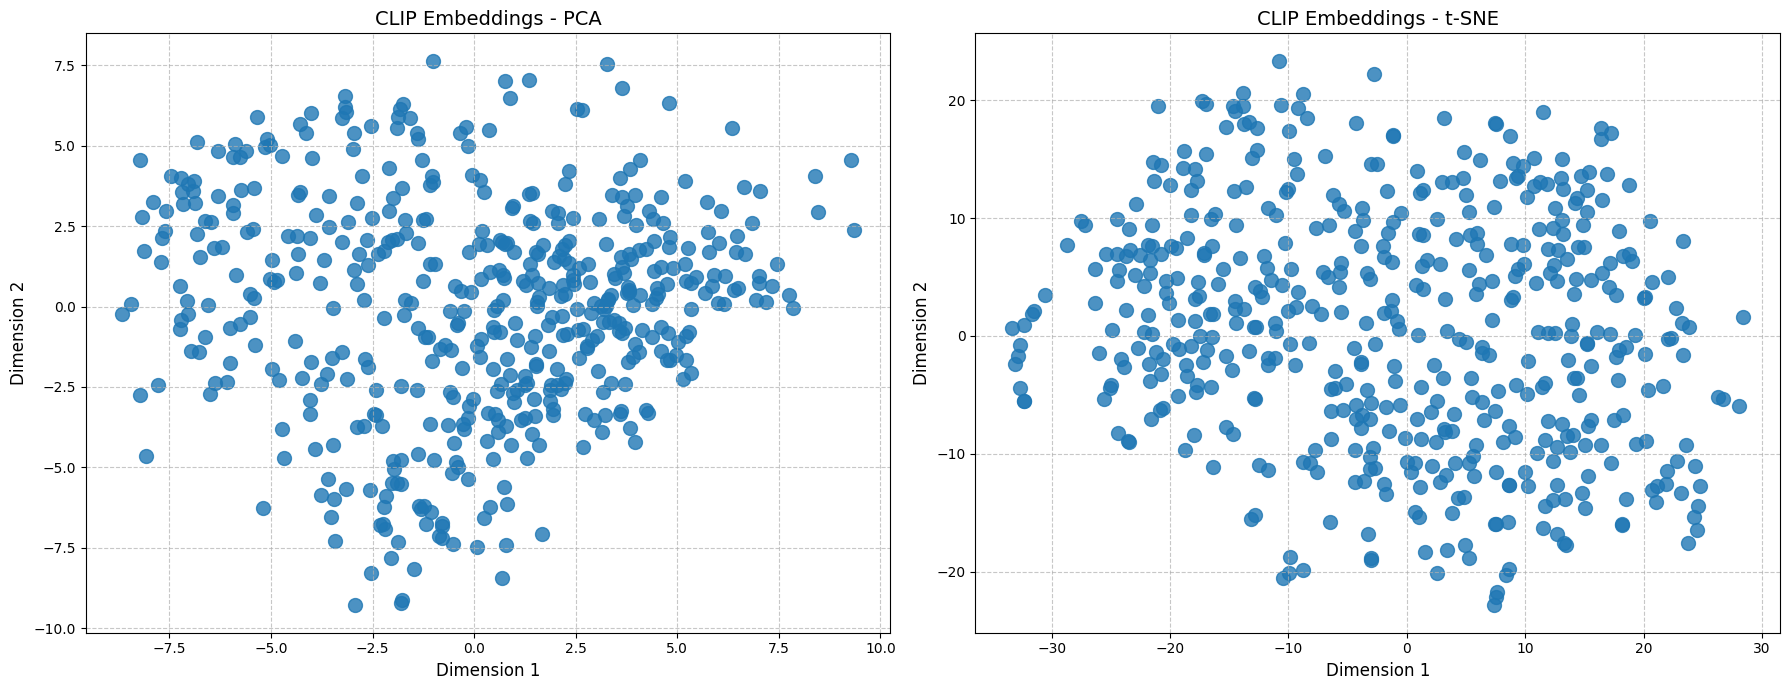


Visualizing CLIP similarity matrix:


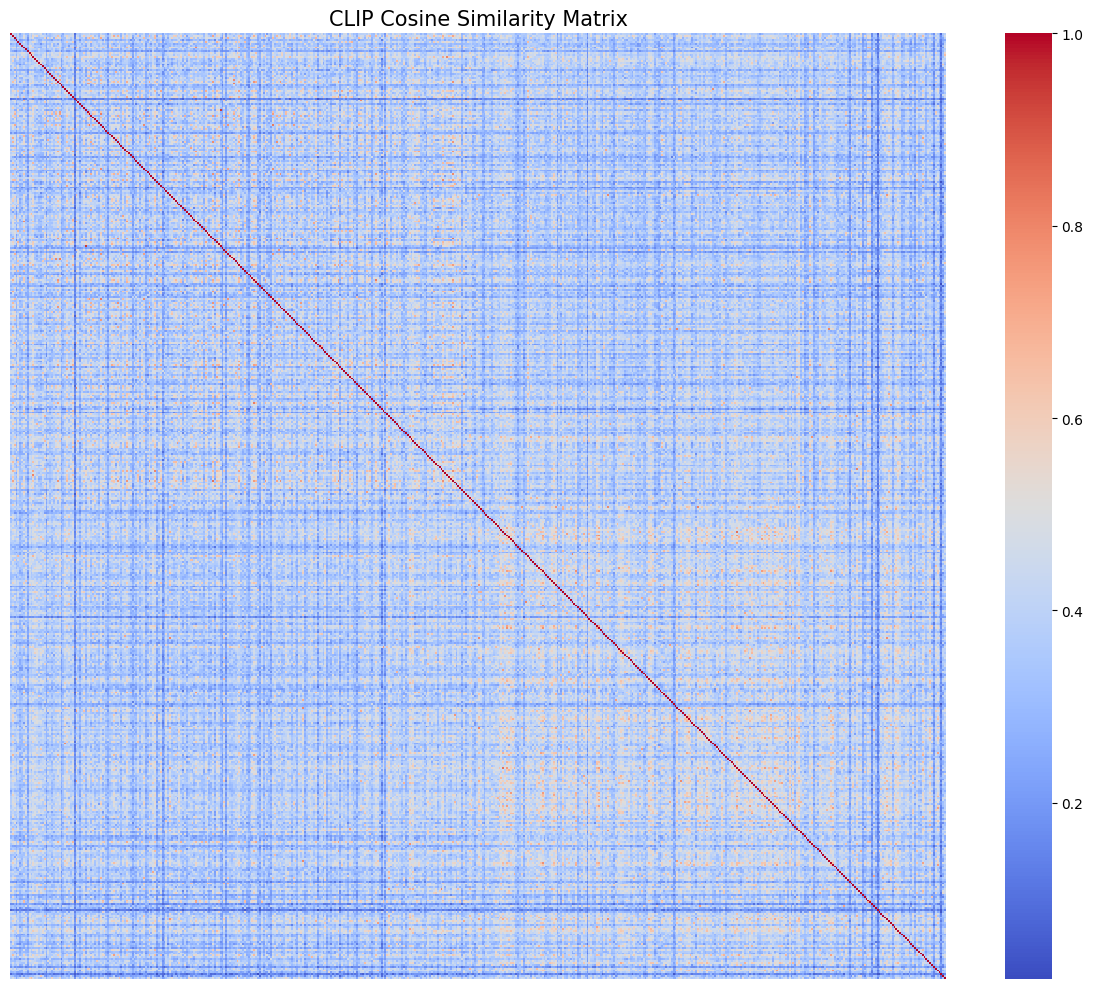

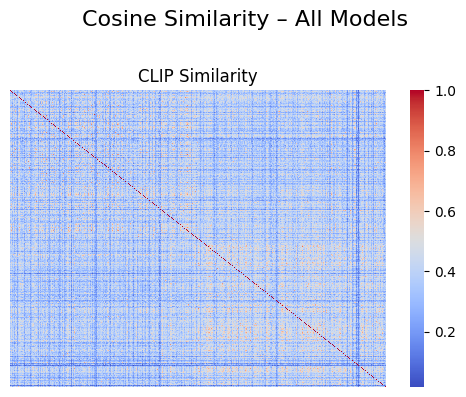

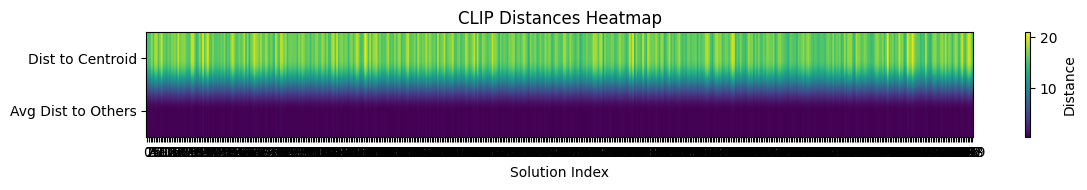

Performing creativity analysis...
Using 3 clusters for analysis based on dataset size (500 samples)

Solution clusters:
Cluster 0: 206 solutions
Cluster 1: 140 solutions
Cluster 2: 154 solutions


e:\langs\miniconda3\envs\dl\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



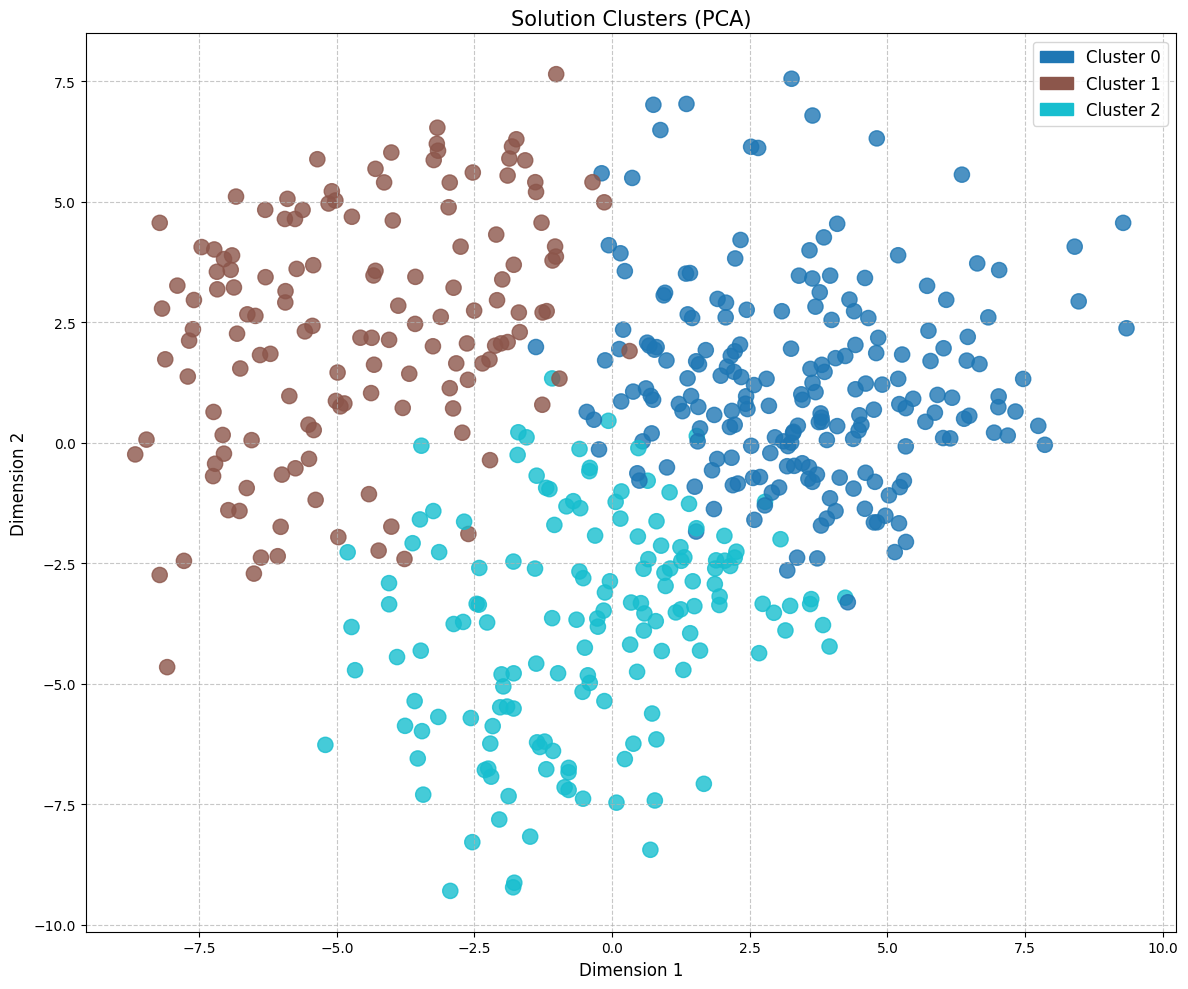

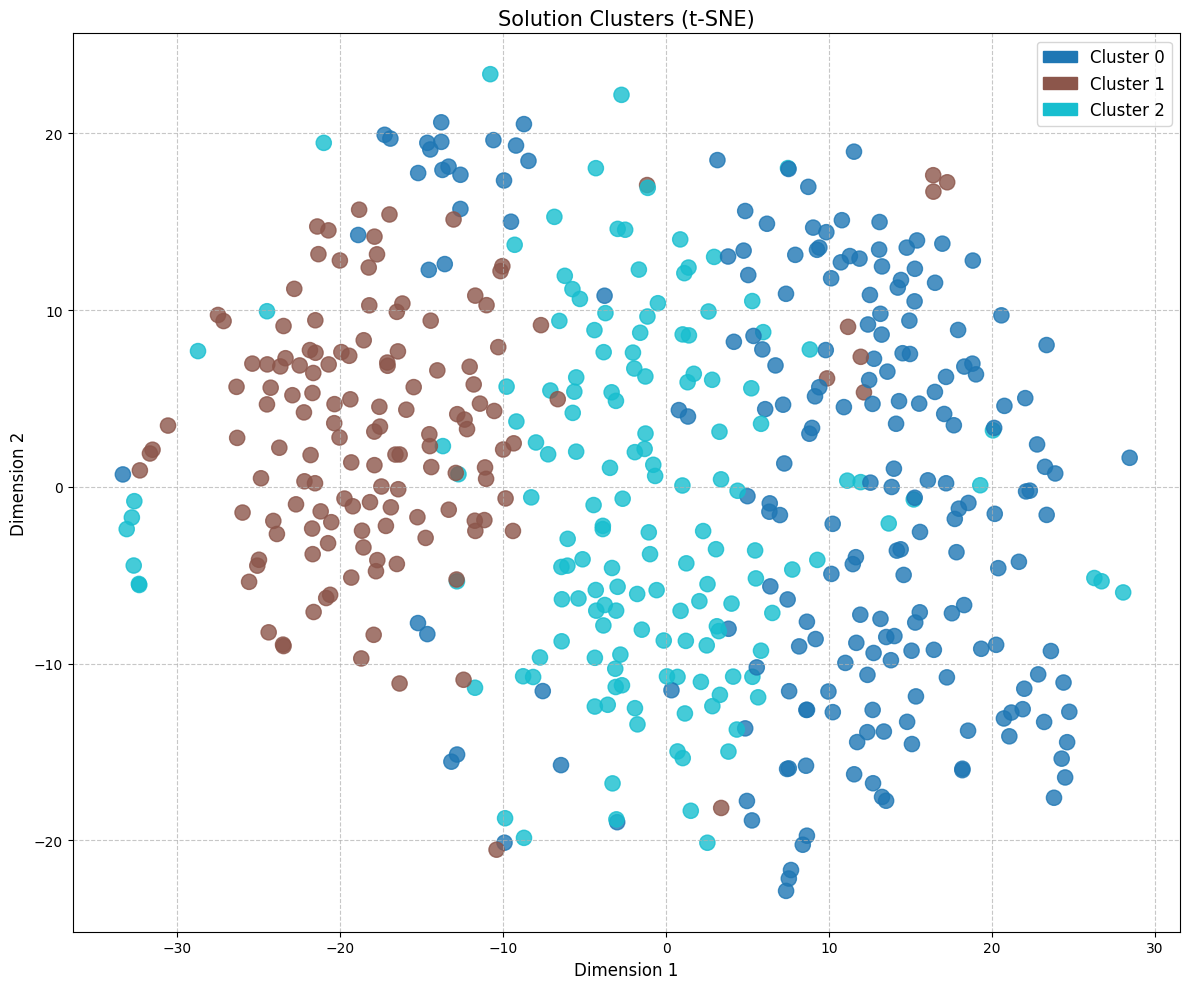


Diversity metrics:
mean_distance_to_centroid: 16.5000
max_distance_to_centroid: 21.0000
mean_pairwise_distance: 0.6203
max_pairwise_distance: 0.9832
variance_explained_ratio: 0.0073


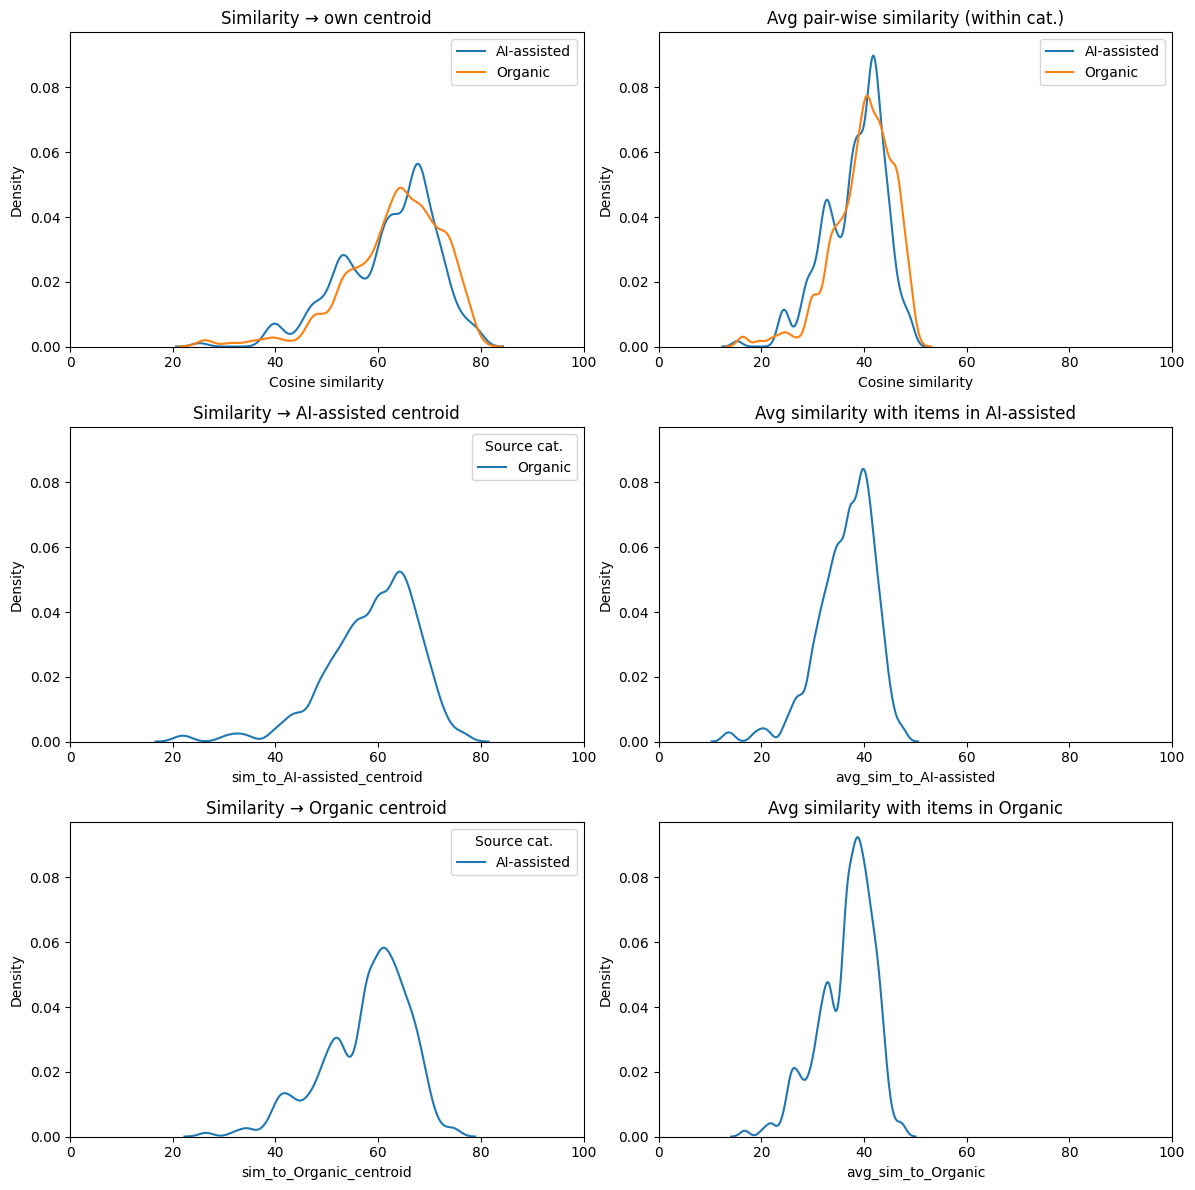

C:\Users\ericb\AppData\Local\Temp\ipykernel_31224\1080822652.py:132: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



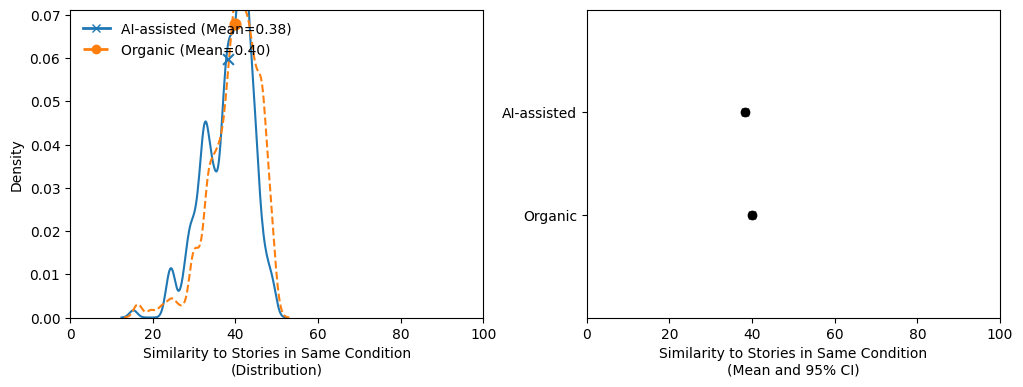

C:\Users\ericb\AppData\Local\Temp\ipykernel_31224\1080822652.py:132: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



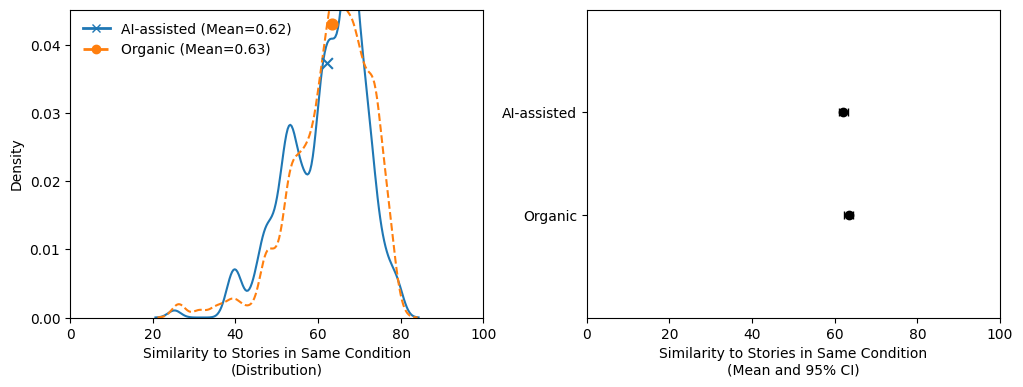

C:\Users\ericb\AppData\Local\Temp\ipykernel_31224\1080822652.py:132: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



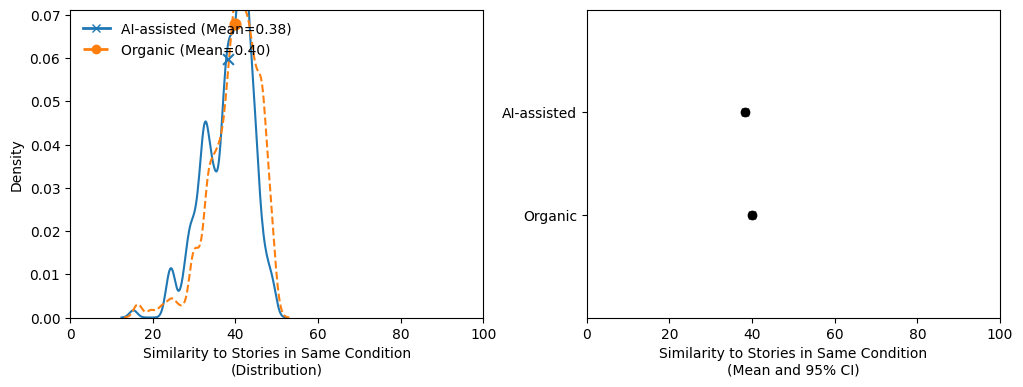

C:\Users\ericb\AppData\Local\Temp\ipykernel_31224\1080822652.py:132: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



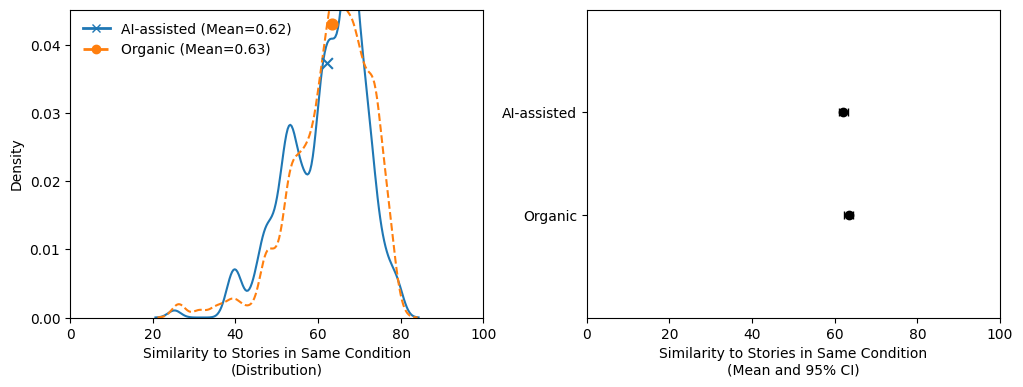

In [52]:
# ----------------------------------------------------------------
# 2) Create text embeddings TODO
# ----------------------------------------------------------------
# TODO (text_column): update "text_to_embed" if your text lives in a different column.
# TODO (models): supply any list of supported embedding model names, e.g. ["openai"]. For now, for simplicity, we can use just openai although the code supports EuroBERT and SentenceBERT

embedding_results = analyze_embeddings(df, "embeddings")

# ----------------------------------------------------------------
# 3) Attach embeddings to dataframe: NOTHING TO DO
# ----------------------------------------------------------------
# ➜ Creates a new series with a NumPy array per row – handy for vector ops.

# openai_vectors = embedding_results["openai"]["embeddings"]   # shape = (n_rows, dim)
# df_new = df.copy()
# df_new["openai_embedding"] = list(openai_vectors)            # each row gets its vector

# ----------------------------------------------------------------
# 4) Diagnostics – similarity matrices & heat-maps: NOTHING TO DO
# ----------------------------------------------------------------
#   • assess how different models arrange items in vector space
#   • useful sanity check that embeddings look reasonable

compare_similarity_matrices(
    embedding_results,
    title="Cosine Similarity – All Models"
)

plot_distance_heatmaps(embedding_results)                    # row/col = samples

# ----------------------------------------------------------------
# 5) Clustering-based “creativity” or diversity measure: NOTHING TO DO
# ----------------------------------------------------------------
# TODO (optional): swap `analyze_creativity` for your own clustering logic but for now probably not needed.

df_with_clusters = analyze_creativity(df, 'embeddings')

# ----------------------------------------------------------------
# 6) Category-level pairwise similarity distributions: TODO
# ----------------------------------------------------------------
# TODO (category_col): change "Level" to whatever column stores your labels.
# TODO (merge_map*): adjust these dicts to merge granular labels into broader buckets.
# For instance, Jackie and Léonard's data has 7 different settings: one human crowd, and 6 different types of human + AI.
# But for the sake of analysis we can join the AI categories into one thanks to the function merge_map.

# merge_map = {
#     # new_label : [list, of, original, labels]
#     "AI": ["0", "1", "2", "A", "B", "C"],
#     "Human" : ["H"]
# }

# merge_map_2 = {
#     "AI Multiple Instance": ["0", "1", "2"],
#     "AI Single Instance"  : ["A", "B", "C"],
#     "Human" : ["H"]
# }

# Distribution of cosine similarities within each category
df_stats = category_similarity_distributions(
    df,
    embedding_col="embeddings",
    category_col="label",          # <-- TODO label column in your dataset
    combine_map=None,
    bw_adjust=0.5,
    scale_to_percent=True
)

# ----------------------------------------------------------------
# 7) Density plots with bootstrapped mean ± CI
# ----------------------------------------------------------------
#   • create one plot per way of grouping your data

# 7a) with first merging rule
plot_density_and_meanCI(
    df_stats,
    value_col="avg_pairwise_samecat", #this will compute with the average pairwise distance
    group_col="label",
    scale_to_percent=True,
    bw_adjust=0.5,
    combine_map=None #TODO specify the merge_map
)

plot_density_and_meanCI(
    df_stats,
    value_col="sim_to_cat_mean", #this will compute with the distance to the centroid embedding
    group_col="label",
    scale_to_percent=True,
    bw_adjust=0.5,
    combine_map=None
)

# 7b) with alternative merging rule
plot_density_and_meanCI(
    df_stats,
    value_col="avg_pairwise_samecat", #this will compute with the average pairwise distance
    group_col="label",
    scale_to_percent=True,
    bw_adjust=0.5,
    combine_map=None
)

plot_density_and_meanCI(
    df_stats,
    value_col="sim_to_cat_mean", #this will compute with the distance to the centroid embedding
    group_col="label",
    scale_to_percent=True,
    bw_adjust=0.5,
    combine_map=None
)